In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import BarycentricInterpolator, CubicSpline
from scipy.special import roots_chebyt, roots_legendre
from numpy.polynomial.polynomial import polyvalfromroots

# Cvičení 10: Interpolace

---
- [poznámky z přednášky - polynomiální interpolace](https://www.karlin.mff.cuni.cz/~kucera/ZNM/5%20-%20Interpolace.pdf)
- [poznámky z přednášky - interpolace pomocí splinů](https://www.karlin.mff.cuni.cz/~kucera/ZNM/6%20-%20Spline%20funkce.pdf)
- další materiály
  - skripta [Dolejší: Fundamentals of Numerical Mathematics](https://www.karlin.mff.cuni.cz/~dolejsi/Vyuka/ZNM.pdf) (Kapitola 4)
  - částečně dostupná (a hodně pokročilá) kniha [Trefethen: Approximation Theory and Approximation Practice](https://www.chebfun.org/ATAP/atap-first6chapters.pdf) (Kapitoly 4, 5 a 6)
  - skripta [Foundations of Applied Mathematics](https://foundations-of-applied-mathematics.github.io/) (Volume 2, Kapitola 10)

- ***Primární úlohy*** : A1, A2, B1, B2

- ***Úlohy k bonusové části zkoušky*** : ZÚ - srovnání formulací Lagrangeovy interpolace, A3

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím porovnat Lagrangeovu interpolaci na ekvidistantních bodech a na Chebyshevových bodech.
  - Umím podložit/zdůvodnit/odvodit pozorované rozdíly těchto interpolací.
  - Umím odvodit podmíněnost problému interpolace v $n$ bodech.
  - Umím definovat lineární a kubický spline pro interpolaci v daných bodech.
  - Umím porovnat polynomiální a spline interpolaci.
---

## Intro

Cíl interpolace na reálné ose je jednoduchý - pro dané body $(x_0,f_0), (x_1,f_1), \dotsc , (x_n,f_n) \in \mathbb{R}^2$ najít funkci $\phi_n(x)$, se kterou můžeme snadno pracovat a která splňuje tzv. *interpolační podmínky*, tj.

$$
\phi_n(x_i) = f_i\quad \mathrm{pro} \quad i = 0,1,\dots,n.
$$

Klasické volby "funkce, se kterou se snadno pracuje" jsou polynomiální funkce (budeme značit $p_n(x)$ místo $\phi_n(x)$) a po částech polynomiální funkce (budeme značit $s_n(x)$ místo $\phi_n(x)$). To nejsou jediné možné volby (lze používat i trigonometrické funkce/polynomy), ale na ostatní nám v základním kurzu bohužel nezbývá čas.

Interpolace je skoro z definice fundamentální nástroj pro predikci jevů na základě nasbíraných dat, také hraje zcela zásadní roli při numerické aproximaci řešení differenciálních rovnic (a zvláště pak parciálních diferenciálních rovnic) a v mnoha dalších odvětvích.

## Část A: Polynomiální interpolace

Na přednášce jsme viděli Lagrangeovu interpolaci ve formě

$$
  p_n(x) =
  \sum_{i=0}^{n} \; f_i \cdot  \underbrace{ \prod\limits_{k\neq i} \frac{ x-x_k }{x_i-x_k} }_{=: \, \ell_i(x)}, \qquad (\star)
$$

pro dané interpolační body $(x_i,f_i)_{i=0,\dotsc ,n}$ a z nich odvozené [Lagrangeovy bazické polynomy](https://en.wikipedia.org/wiki/Lagrange_polynomial#Definition) $\ell_i(x)$. Tato formulka vypadá vcelku nevinně, ale ve skutečnosti může představovat pro výpočet na počítači velký problém. K detailům se dostaneme v dalším týdnu a nyní si pouze ukážeme, že lze $p_n(x)$ napsat i jinak, v tzv. ***barycentrické formě***.

Nejprve si zavedeme dvě nové veličiny - polynom $\ell(x)$ a váhy $w_i$ - jako

$$ \ell (x) := \prod\limits_{k=0}^n ( x-x_k ) \quad \mathrm{a} \quad w_i :=  \frac{1}{ \prod\limits_{k\neq i} x_i-x_k }. $$

Jejich použitím lze vcelku přímo odvodit

$$
\ell_i (x) = \ell(x) \cdot \frac{w_i}{x-x_i} \qquad
\mathrm{a \; tedy \;} \qquad p_n(x) = \sum_{i=0}^{n} \; f_i \cdot \ell(x) \cdot \frac{w_i}{x-x_i} = \ell(x) \cdot \sum_{i=0}^{n} \; f_i \frac{w_i}{x-x_i}.
$$

Pokud si vezmeme $f_i=1$ pro všechna $i=0,\dotsc ,n$, zjevně bude platit $p_n(x) \equiv 1$ (každý polynom $n$-tého stupně je jednoznačně určený $n+1$ body). Pro libovolnou volbu bodů tedy musí platit

$$
1 = \ell(x) \cdot \sum_{i=0}^{n} \frac{w_i}{x-x_i} \qquad
\mathrm{nebo-li \;} \qquad \ell(x) = \frac{1}{ \sum_{i=0}^{n} \frac{w_i}{x-x_i} }.
$$

Všimněte si, že výraz na pravé strně ***vůbec nevypadá jako polynom*** a přesto je s $p_n(x)$ identický. Použitím tohoto vztahu dostáváme tzv. [***barycentrickou formu Lagrangeovy interpolace***](https://en.wikipedia.org/wiki/Lagrange_polynomial#Barycentric_form)


$$
  p_n(x) = \frac{
  \sum_{i=0}^{n} \frac{w_i}{x-x_i} f_i
  }{
  \sum_{i=0}^{n} \frac{w_i}{x-x_i}
  }
  \quad \mathrm{kde} \quad
  w_i := \frac{1}{ \prod_{k\neq i} x_i-x_k }. \qquad (\mathrm{B})
$$

Tahle formulka je, oproti té původní, pro výpočet na počítači mnohem vhodnější, takže všechny rozumné implementace pracují s ní.

> Všímavým neunikne, že pro vyhodnocení $(\mathrm{B})$ vlastně žádný polynom konstruovat nemusíme!



Přirozeně nás zajímá, jak velké chyby se při použití $p_n(x)$ místo $f(x)$ dopouštíme, nebo-li nás zajímá interpolační chyba/error

$$
 err_f(x,n) = f(x) - p_n(x).
$$

### ZÚ - srovnání formulací Lagrangeovy interpolace

---
**Tužka a papír** :
- Kolik operací (sčítání/odčítání/násobení/dělení) je zapotřebí provést pro vyhodnocení $p_n(x)$ ve formě $(\star)$?
- Kolik operací (sčítání/odčítání/násobení/dělení) je zapotřebí provést pro vyhodnocení $p_n(x)$ ve formě $(\mathrm{B})$?
- Pokud víme, že budeme $p_n(x)$ vyhodnocovat v mnoha bodech $x$, lze si kus výpočtu "předpočítat" pro dané interpolační body $x_0,\dotsc ,x_n$ pro formulaci $(\star)$ nebo $(\mathrm{B})$? Pokud si něco předpočítáme, kolik operací pak potřebujeme k vyhodnocení $(\star)$ nebo $(\mathrm{B})$?
- Pro některé volby interpolačních bodů $x_0,\dotsc ,x_n$ paltí, že $w_i = C^n \tilde{w}_i$, kde $\tilde{w}_i$ už nezávisí na $n$ - tedy váhy $w_i$ exponenciálně rostou/klesají s počtem interpolačních bodů jako $C^n$, pro nějakou (často známou) konstantu $C>0$.
  - Pokud $C=10$, od jaké hodnotě $n$ hrozí, že nebudeme schopni formulaci $(\star)$ použít, kvůli FPA limitacím?
  - Pokud $C=10$, adaptujte formulaci $(\mathrm{B})$ tak, aby se z větší části FPA limitacím vyhla.
  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>
  
    Jak se změní hodnota $p_n(x)$ ve formulaci $(\mathrm{B})$, pokud v $(\mathrm{B})$ dosadíme místo $w_i$ hodnoty $\alpha w_i$? Jak lze volit $\alpha$, abychoms e vyhnuli problémům s výpočtem s $w_i$ v našem případě?

  </details>
---

### Úloha A1 - Lagrangeova barycentrická interpolace

V modulu `scipy.interpolate` si najdeme funkci [`BarycentricInterpolator()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BarycentricInterpolator.html#scipy.interpolate.BarycentricInterpolator) a použijeme jí k interpolaci funkcí - je to efektivní implementace formulace $(\mathrm{B})$. Outputem je objekt, který se chová jako polynom - můžeme ho volat na libovolná vstupní data a na výstupu dostaneme odpovídající hodnoty, např. pokud `InterpPoly = BarycentricInterpolator(x,y)`, pak dostaneme `InterpPoly(x) = y`.

---
**Kódění** :
- Naimplementujte funkce `LagrangeuvInterpPolynom()` a `LagrangeuvInterpPolynom_Chyba()` podle anotace níže.
- Doplňte kódy níže tak, aby
  - první kód vykresloval interpolaci, tj. funkční hodnoty $f(x)$, interpolační hodnoty $p_n(x)$,
  - druhý kód vykresloval chybu interpolace.

- Zformulujte společné rysy, které pozorujete pro různé volby $n$ (a případně i pro různé volby $f$ a/nebo intervalu $[a,b]$, například $f(x) = e^{x} \;\&\; [a,b]=[-1,1]$ nebo $f(x) = |x|+\frac{x}{2} - x^2 \;\&\; [a,b]=[-1,1]$).

---

In [ ]:
def LagrangeuvInterpPolynom(f,x_interp):
  '''
  Pro danou funkci "f" a interpolacni body "x_interp" vratime interpolacni funkci zkonstruovanou pomoci "BarycentricInterpolator()".

  Input
  -------
  f :   python funkce (callable). Funkce vyhodnocujici hodnoty "f : R -> R",
        syntax "f( np.array([x1,...,xn]) )" je akceptovan a vraci output "np.array([f(x1),...,f(xn)])"
  x_interp :  np.array dimenze "n+1" s prvky np.float64. Interpolacni body - rad interpolace je zadan implicitne delkou tohoto pole.

  Output
  -------
  Objekty typu "BarycentricInterpolator"
  '''
  # Váš kód
  return BarycentricInterpolator(x_interp, f(x_interp))


########################################################################
def f(x):
  return np.sin(x)**2 - np.exp(x/10)

def test_LagrangeuvInterpPolynom():
    for n in range(5,10):
      a = 0; b = 6; x_inter = np.linspace(a,b,n+1)
      InterpPoly = LagrangeuvInterpPolynom(f,x_inter)
      assert np.allclose( InterpPoly(x_inter), f(x_inter) ), "`p(x_i) = f(x_i)` by mělo platit přesně ve všech interpolačních bodech, ale mame p(x_i) = {} & f(x_i) = {}".format(InterpPoly(x_inter), f(x_inter))
    return '"LagrangeuvInterpPolynom()" je OK'

test_LagrangeuvInterpPolynom()

'"LagrangeuvInterpPolynom()" je OK'

In [ ]:
def LagrangeuvInterpPolynom_Chyba(f,x_interp,x_chyba):
  '''
  Pro danou funkci "f" a interpolacni body "x_interp" spocitame chybu interpolacni funkce (zkonstruovanou pomoci "BarycentricInterpolator()") v bodech "x_chyba".

  Input
  -------
  f :   python funkce (callable). Funkce vyhodnocujici hodnoty "f : R -> R",
        syntax "f( np.array([x1,...,xn]) )" je akceptovan a vraci output "np.array([f(x1),...,f(xn)])"
  x_interp :  np.array dimenze "n+1" s prvky np.float64. Interpolacni body - rad interpolace je zadan implicitne delkou tohoto pole.
  x_chyba :  np.array dimenze "m" s prvky np.float64. Body ve kterych chci vyhodnotit chybu itnerpolace "f - BarycentricInterpolator()"

  Output
  -------
  InterpChyba :  np.array dimenze "m" s prvky np.float64. Hodnoty chyby itnerpolace "f - BarycentricInterpolator()" v bodech "x_chyba".
  '''
  # Váš kód
  Interpolant = BarycentricInterpolator(x_interp, f(x_interp));
  return f(xi_chyba) - Interpolant(xi_chyba)


########################################################################
def f(x):
  return np.exp(x)

def test_LagrangeuvInterpPolynom_Chyba():
    for n in range(5,10):
      a = 0; b = 6; x_inter = np.linspace(a,b,n+1);
      xi_chyba = x_inter; InterpChyba = LagrangeuvInterpPolynom_Chyba(f,x_inter,xi_chyba)
      assert np.linalg.norm(InterpChyba) <= 1e-12 , "Mělo by platit 'LagrangeuvInterpPolynom_Chyba(f,x_inter,x_inter) == np.zeros(m)', ale dostavame = {}".format(InterpChyba)

    xi_chyba = np.linspace(a,b,100); InterpChyba = LagrangeuvInterpPolynom_Chyba(f,x_inter,xi_chyba); # print( np.max( np.abs(InterpChyba) )) by melo odpovidat ~ 6.2 * 1e-3
    assert np.max( np.abs(InterpChyba) ) <= 1e-2, "Konkretni vysledek nevychazi jak ma - porad se se cvicicim"
    return '"LagrangeuvInterpPolynom_Chyba()" je OK'

test_LagrangeuvInterpPolynom_Chyba()

'"LagrangeuvInterpPolynom_Chyba()" je OK'

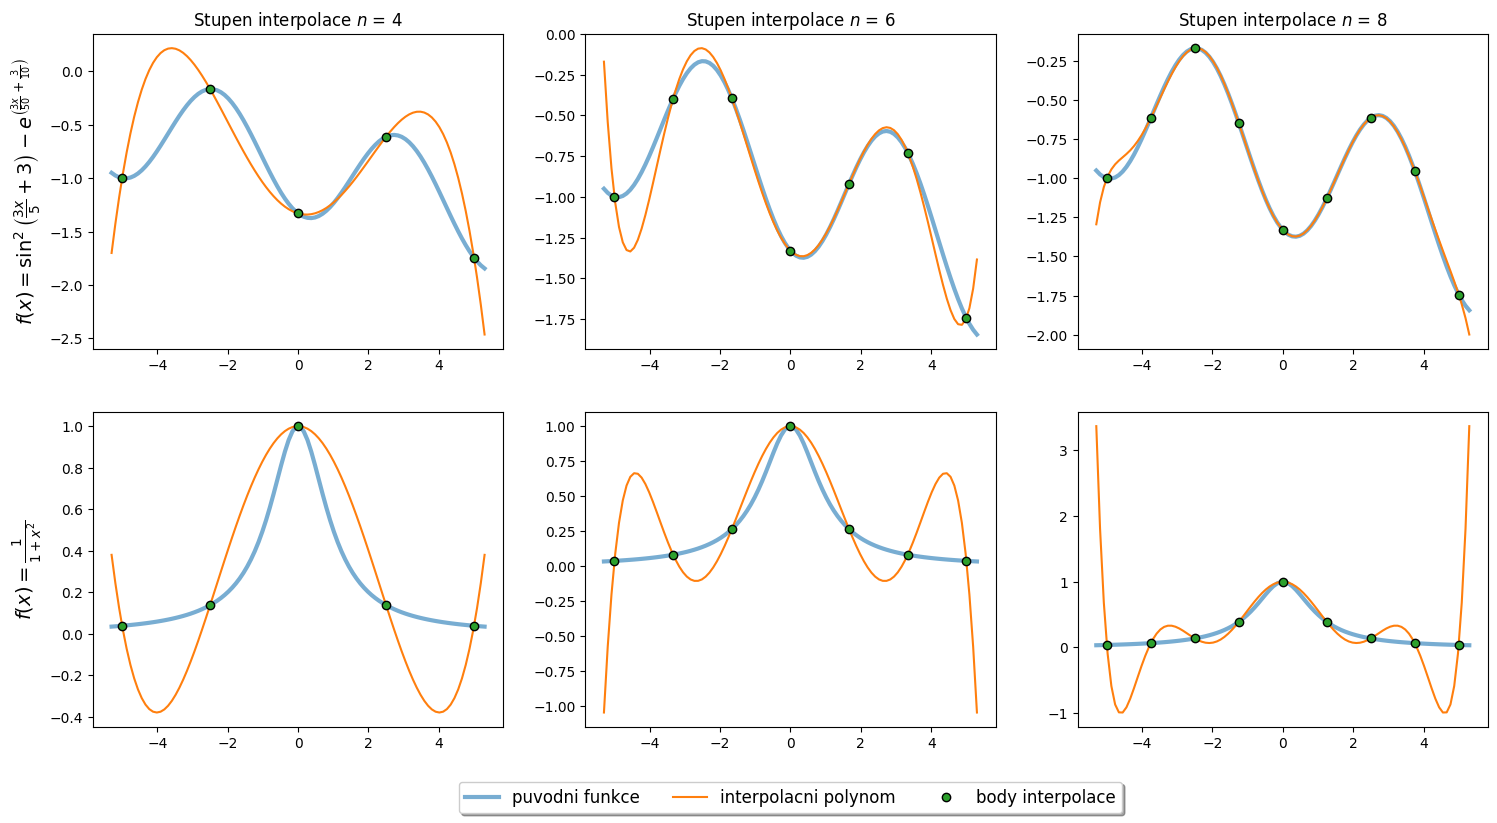

In [ ]:
def f1(x):
  return np.sin(3/5*x+3)**2 - np.exp( (3/5*x+3)/10 )
def f2(x):
  return 1/(1+x**2)

n_totry = np.array([4,6,8])
a = -5; b = 5; xi_chyba = np.linspace(a,b,500)

fig = plt.figure(figsize=(18,9))
x_plot = np.linspace(a-.3, b+0.3, 100)


for ind_n in range(0,len(n_totry)):

  x_inter = np.linspace(a,b,n_totry[ind_n]+1);

  InterpPoly_f1 = LagrangeuvInterpPolynom(f1,x_inter)
  InterpPoly_f2 = LagrangeuvInterpPolynom(f2,x_inter)

  ############################## Vykreslovani
  plt.subplot(2,3,ind_n+1)
  plt.plot(x_plot, f1(x_plot), label="funkce $f(x)$", lw=3, alpha=.6)
  plt.plot(x_plot, InterpPoly_f1(x_plot), label="interpolacni polynom $p_n(x)$")
  plt.plot(x_inter, f1(x_inter), "o", markeredgecolor='k', label="interpolacni body $(x_i,f_i)$")
  plt.title("Stupen interpolace $n$ = {}".format(n_totry[ind_n]))
  if ind_n == 0:
    plt.ylabel(r"$f(x) = \sin^2\left( \frac{3x}{5}+3 \right) - e^{  \left( \frac{3x}{50} +  \frac{3}{10} \right) }$", fontsize=14)

  plt.subplot(2,3,ind_n+4)
  plt.plot(x_plot, f2(x_plot), label="puvodni funkce", lw=3, alpha=.6)
  plt.plot(x_plot, InterpPoly_f2(x_plot), label="interpolacni polynom")
  plt.plot(x_inter, f2(x_inter), "o", markeredgecolor='k', label="body interpolace")
  if ind_n == 0:
    plt.ylabel(r"$f(x) = \frac{1}{1+x^2}$", fontsize=14)
  if ind_n == 1:
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5, fontsize=12);
  ############################## Vykreslovani

plt.show()

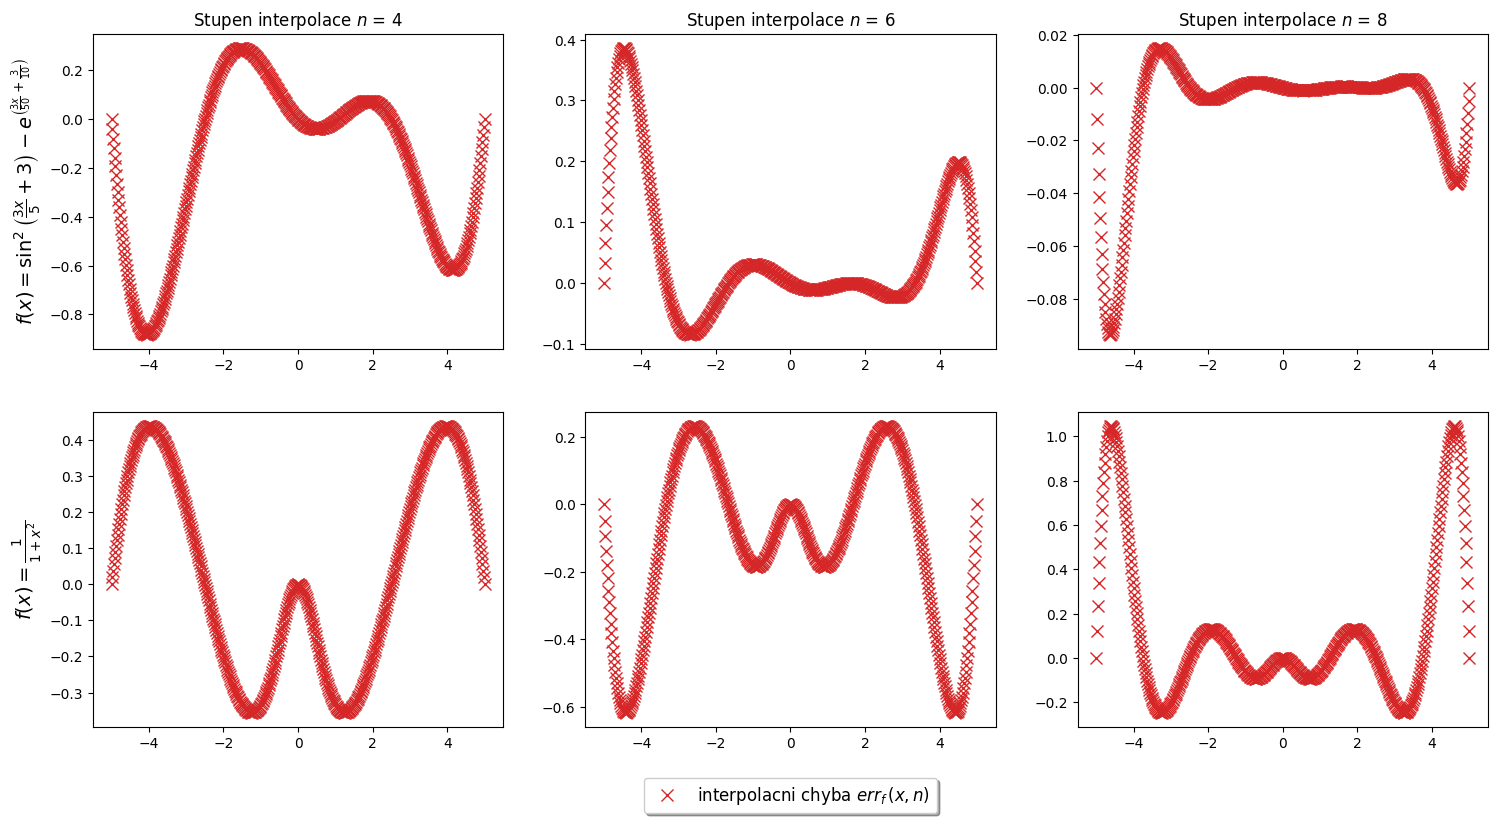

In [ ]:
def f1(x):
  return np.sin(3/5*x+3)**2 - np.exp( (3/5*x+3)/10 )
def f2(x):
  return 1/(1+x**2)

n_totry = np.array([4,6,8])
a = -5; b = 5; xi_chyba = np.linspace(a,b,500)

fig = plt.figure(figsize=(18,9))
x_chyba = np.linspace(a-.3, b+0.3, 100)


for ind_n in range(0,len(n_totry)):

  x_inter = np.linspace(a,b,n_totry[ind_n]+1);

  InterpPoly_Chyba_f1 = LagrangeuvInterpPolynom_Chyba(f1,x_inter,xi_chyba)
  InterpPoly_Chyba_f2 = LagrangeuvInterpPolynom_Chyba(f2,x_inter,xi_chyba)

  ############################## Vykreslovani
  plt.subplot(2,3,ind_n+1)

  plt.plot(xi_chyba, InterpPoly_Chyba_f1, 'x', ms=8, c='tab:red', lw=0, label="interpolacni chyba $err_f(x)$")
  plt.title("Stupen interpolace $n$ = {}".format(n_totry[ind_n]))
  if ind_n == 0:
    plt.ylabel(r"$f(x) = \sin^2\left( \frac{3x}{5}+3 \right) - e^{  \left( \frac{3x}{50} +  \frac{3}{10} \right) }$", fontsize=14)

  plt.subplot(2,3,ind_n+4)
  plt.plot(xi_chyba, InterpPoly_Chyba_f2, 'x', ms=8, c='tab:red', lw=0, label="interpolacni chyba $err_f \, (x,n)$")
  if ind_n == 0:
    plt.ylabel(r"$f(x) = \frac{1}{1+x^2}$", fontsize=14)
  if ind_n == 1:
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5, fontsize=12);
  ############################## Vykreslovani

plt.show()

### Úloha A2 - interpolační chyba

Z přednášky víme, že pro chybu Lagrangeovi interpolace platí

$$
 err_f(x,n) \equiv f(x) - p_n(x) =  \frac{ f^{(n+1)}(\zeta) }{(n+1)!} \cdot (x-x_0) \cdot \dotsc \cdot (x-x_n) ,
$$

pro nějaké $\zeta \in (a,b)$ (tj. existuje takový bod $\zeta\equiv \zeta(x) \in (a,b)$, že platí rovnost výše).

Pro danou funkci $f(x)$ máme - v nejlepším případě - možnost volby stupně interpolace $n$ a interpolačních bodů $x_0,\dotsc ,x_n$. Vhodnou volbou těchto parametrů bychom rádi minimalizovali $\infty$-normu interpolační chyby, tj.

$$
E_f(n) := \max\limits_{x\in [a,b]} \left| err_f(x,n) \right|
\leq  \max\limits_{x\in [a,b]} \left| \frac{ f^{(n+1)}(x) }{(n+1)!} \right|\cdot \max\limits_{x\in [a,b]} \left| (x-x_0) \cdot \dotsc \cdot (x-x_n) \right|.
$$

Předpokládejme, že $f$ je hladká a tedy $f^{(n+1)}$ je omezená funkce na $[a,b]$. Zjevně větší $n$ znamená větší člen $(n+1)!$ a tudíž zmenšení odhadu výše.

---
**Tužka a papír** :
- Formulujte hledání optimálních bodů $x_0,\dotsc ,x_n$ pro minimalizaci ***horního odhadu*** $E_f(n)$ výše jako min-max problém.
- Vyřešte tento problém pomocí znalostí speciálních funkcí z minulých přednášek/cvičení.
  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>

  Formulujte ten min-max problém výše skrze polynomy - jaký je stupeň polynomu $(x-x_0) \cdot \dotsc \cdot (x-x_n)$ a jaký je jeho vedoucího koeficient?

  </details>

- Jaká je tedy dobrá volba bodů $x_0,\dotsc ,x_n \in [a,b]$, cheme-li malou chybu $E_f(n)$ (**DÚ** vyjádřit explicitně)?

- Níže je připravený kód, který by měl vaše řešení ilustrovat - detailně vysvětlete, co daný kód vykresluje a jak to ne/odpovídá teorii výše. Své vysvětlení podložte dalšími vlastními experimenty pro různé volby $n$ (a případně i $f$ nebo $[a,b]$).

- **ZÚ** : Explicitně vyjádřete, ve kterých bodech nabývá horní odhad na $E_f(n)$ svého maxima pro a jak to odpovídá obrázku níže.

---

---
***Řešení:***
- $$ \min\limits_{x_0,\dotsc , x_n \in [a,b]} \max\limits_{x\in [a,b]} \left| \frac{ f^{(n+1)}(x) }{(n+1)!} \right|\cdot \max\limits_{x\in [a,b]} \left| (x-x_0) \cdot \dotsc \cdot (x-x_n) \right| = \\ = \dotsc =
\max\limits_{x\in [a,b]} \left| \frac{ f^{(n+1)}(x) }{(n+1)!}  \right| \cdot \min\limits_{q_n\in \mathcal{Q}_{n+1}} \max\limits_{x\in [a,b]} \left| q_{n+1}(x) \right|,$$
kde $\mathcal{Q}_{n+1}$ je množina všech monických polynomů stupně $n+1$.

- tedy z předchozího cvika/přednášky víme, že řešením je vzít $q_{n+1}(x)$ jako ...

- tedy optimální volbou $x_0,\dotsc ,x_n$ jsou kořeny ... a díky minulému cviku známe i explicitní formulku $x_i=\dotsc$.

---

***Ilustrace***

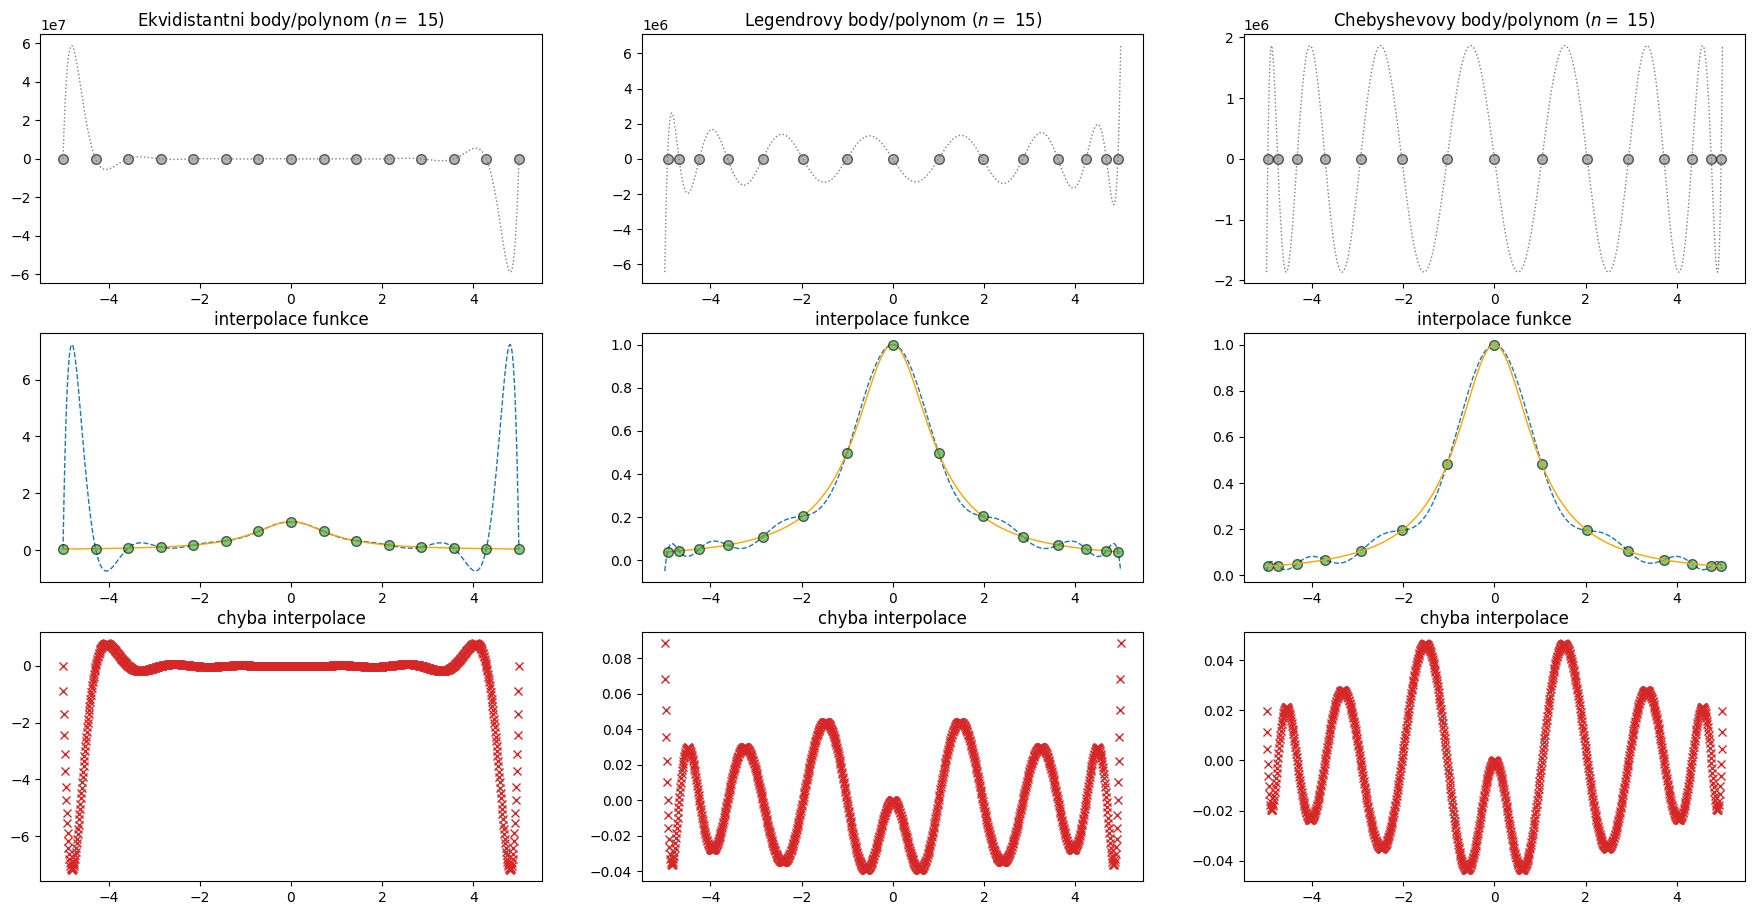

In [ ]:
def f(x):
    return 1/(1+x**2)


a = -5; b = 5; n = 15;


fig, [[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]] = plt.subplots(nrows=3, ncols=3, figsize=(22, 11), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
MyColors = ["tab:gray","tab:blue","orange","tab:green","tab:red"]

x_eval = np.linspace(a,b,1000)
x_cheb = 5*roots_chebyt(n)[0]; p_InterpCheb = LagrangeuvInterpPolynom(f,x_cheb); chyba_InterpCheb = LagrangeuvInterpPolynom_Chyba(f,x_cheb,x_eval);
x_leg = 5*roots_legendre(n)[0]; p_InterpLeg = LagrangeuvInterpPolynom(f,x_leg); chyba_InterpLeg = LagrangeuvInterpPolynom_Chyba(f,x_leg,x_eval);
x_equi = np.linspace(a,b,n); p_InterpEqui = LagrangeuvInterpPolynom(f,x_equi); chyba_InterpEqui = LagrangeuvInterpPolynom_Chyba(f,x_equi,x_eval);

### equi
ax1.set_title(r"Ekvidistantni body/polynom ($n=$ {})".format(n))
ax1.plot(x_equi, np.zeros(len(x_equi)), lw=0, marker ="o", c = MyColors[0], alpha=.6, ms=7, markeredgecolor="k");
ax1.plot(x_eval, polyvalfromroots(x_eval, x_equi), ':', c = MyColors[0], label="n = {}".format(n), lw=1)

ax4.set_title(r"interpolace funkce")
ax4.plot(x_eval, p_InterpEqui(x_eval), '--', c = MyColors[1], label="n = {}".format(n), lw=1)
ax4.plot(x_eval, f(x_eval), '-', c = MyColors[2], label=r"$f(x)$", lw=1)
ax4.plot(x_equi, p_InterpEqui(x_equi), lw=0, c = MyColors[3], marker ="o", alpha=.6, ms=7, markeredgecolor="k");

ax7.set_title(r"chyba interpolace")
ax7.plot(x_eval, chyba_InterpEqui, 'x', c = MyColors[4], label="n = {}".format(n), lw=0)

### leg
ax2.set_title(r"Legendrovy body/polynom ($n=$ {})".format(n))
ax2.plot(x_leg, np.zeros(len(x_leg)), lw=0, marker ="o", c = MyColors[0], alpha=.6, ms=7, markeredgecolor="k");
ax2.plot(x_eval, polyvalfromroots(x_eval, x_leg), ':', c = MyColors[0], label="n = {}".format(n), lw=1)

ax5.set_title(r"interpolace funkce")
ax5.plot(x_eval, p_InterpLeg(x_eval), '--' , c = MyColors[1], label="n = {}".format(n), lw=1)
ax5.plot(x_eval, f(x_eval), '-', c = MyColors[2], label=r"$f(x)$", lw=1)
ax5.plot(x_leg, p_InterpLeg(x_leg), lw=0, c = MyColors[3], marker ="o", alpha=.6, ms=7, markeredgecolor="k");

ax8.set_title(r"chyba interpolace")
ax8.plot(x_eval, chyba_InterpLeg, 'x', c = MyColors[4], label="n = {}".format(n), lw=0)


### cheb
ax3.set_title(r"Chebyshevovy body/polynom ($n=$ {})".format(n))
ax3.plot(x_cheb, np.zeros(len(x_cheb)), lw=0, c = MyColors[0], marker ="o", alpha=.6, ms=7, markeredgecolor="k");
ax3.plot(x_eval, polyvalfromroots(x_eval, x_cheb), ':', c = MyColors[0], label="n = {}".format(n), lw=1)

ax6.set_title(r"interpolace funkce")
ax6.plot(x_eval, p_InterpCheb(x_eval), '--' , c = MyColors[1], label="n = {}".format(n), lw=1)
ax6.plot(x_cheb, p_InterpCheb(x_cheb), lw=0, c = MyColors[3], marker ="o", alpha=.6, ms=7, markeredgecolor="k");
ax6.plot(x_eval, f(x_eval), '-', c = MyColors[2], label=r"$f(x)$", lw=1)

ax9.set_title(r"chyba interpolace")
ax9.plot(x_eval, chyba_InterpCheb, 'x', c = MyColors[4], label="n = {}".format(n), lw=0)

plt.show()

### Úloha A3 - podmíněnost interpolace

Stejně jako u všech ostatních oblastí je i u interpolace důležité si uvědomit, že interpolační hodnoty $f_i$ mohou být zatížené chybou - ať už z důvodu práce v FPA a konečnosti počítače a/nebo chyby měření/simulace atp.

Je tedy na snadě otázka, jak moc se mi může změnit interpolant, pokud trochu změním interpolační podmínky, konkrétně hodnoty $f_0,\dotsc ,f_n$. Jinými slovy, chceme spočítat/odhadnout *podmíněnost* polynomiální interpolace v daných bodech $x_0,\dotsc ,x_n$.

Uvidíme, že odpověď je opět typu "to záleží" a klíčovou hodnotou bude tzv. [Lebesguova konstanta](https://en.wikipedia.org/wiki/Lebesgue_constant), kterou je možno definovat (existuje více způsobů) jako

$$ \Lambda_n(x_0,\dotsc ,x_n) := \max\limits_{x\in [a,b]} \sum\limits_{i=0}^{n} |\ell_i(x)|, $$

kde $\ell_i(x)$ je $i$-tý Lagrngeův bazický polynom daný body $x_0,\dotsc ,x_n$, tj. $\ell_i(x) = \prod_{k\neq i} \frac{x-x_k}{x_i-x_k}$.

Lze ukázat (a více se o tom můžete dozvědět napříkald na předmětu [NMNV543: Aproximace funkcí 1](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NMNV543)), že
  - pro ekvidistantní body platí $\Lambda_n \approx \frac{2^{n+1}}{n\log(n)}$ pro $n\rightarrow +\infty$,
  - pro Chebyshevovy body platí $\Lambda_n \leq 1+ \frac{2}{\pi} \log(n+1)$.

---
**Tužka a papír** : Uvažujme situaci, kdy máme dvě sady interpolačních hodnot, $\mathbf{f} = [f_0,\dotsc ,f_n]^T$ a $\mathbf{g} = [g_0,\dotsc ,g_n]^T$, a označíme si výsledné Lagrangeovy interpolace jako $p_g(x)$ a $p_f(x)$ (a tedy platí $p_f(x_i) = f_i$ a $p_g(x_i) = g_i$).

- Odhadněte $\infty$-normu rozdílu $p_f(x)-p_g(x)$, tj. $\max\limits_{x\in [a,b]} |p_f(x)-p_g(x)|$, na základě rozdílů $|f_i - g_i|, i = 0,\dotsc , n$.
- Co musí splňovat body $x_0,\dotsc ,x_n$ aby polynomiální interpolace v těchto bodech byla dobře podmíněná? Co byste řekli o podmíněnost polynomiální interpolace v ekvidistantních/Chebyshevových bodech?
---

---
***Řešení:***
- $$|p_f(x)-p_g(x)| = \left| \sum\limits_{i=0}^{n} f_i\ell_i(x) - \sum\limits_{i=0}^{n} g_i\ell_i(x) \right| = \dotsc \leq
\max\limits_{i=0,\dotsc ,n} |f_i-g_i| \sum\limits_{i=0}^{n} \left| \ell_i(x) \right| $$

- $$\max\limits_{x\in [a,b]} |p_f(x)-p_g(x)|  \leq \dotsc \leq \Lambda_n(x_0,\dotsc ,x_n) \cdot \max\limits_{i=0,\dotsc ,n} |f_i-g_i|$$

- polynomiální interpolace je dobře podmíněná právě tehdy, když odpovídá bodům z intervalu $[a,b]$ s malou Lebesguovou konstantou. Zjevně tedy není dobře podmíněná v ekvidistantních bodech a je dobře podmíněná v Chebyshevových bodech.

---

### ZÚ - teorie vs praxe

Z praktického hlediska nás zajímá, jak velká je chyba $E_f(n)$. My tuto hodnotu numericky aproximujeme pomocí tzv. *samplování*, tj. vezmeme si $m$ bodů $\eta_1,\dotsc ,\eta_m$ "hustě pokrývajících $[a,b]$" a aproximujeme
$$ E_f(n) \approx \max\limits_{i=1,\dotsc ,m$} \left| f(\eta_i) - p_n(\eta_i) \right|. \qquad (\star)$$

---
**Kódění** : Doplňte kód níže tak, aby vykresloval aproximaci $(\star)$ chyby $E_f(n)$.

**Tužka a papír** : Navíc pro zamyšlení - dokážete určit sklon divergujících křivek $E_f(n)$ pro ekvidistantní body?
  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>

  V principu musíme vždy počítat s chybou řádově $\varepsilon_{mach}\approx 10^{-16}$ v datech $f_0,\dotsc ,f_n$. Pro jak která $n$ bude tato chyba viditelně ovlivňovat přesnost interpolace? Použijte odvozené výsledky o podmíněnosti polynomiální interpolace.

  </details>
  
---

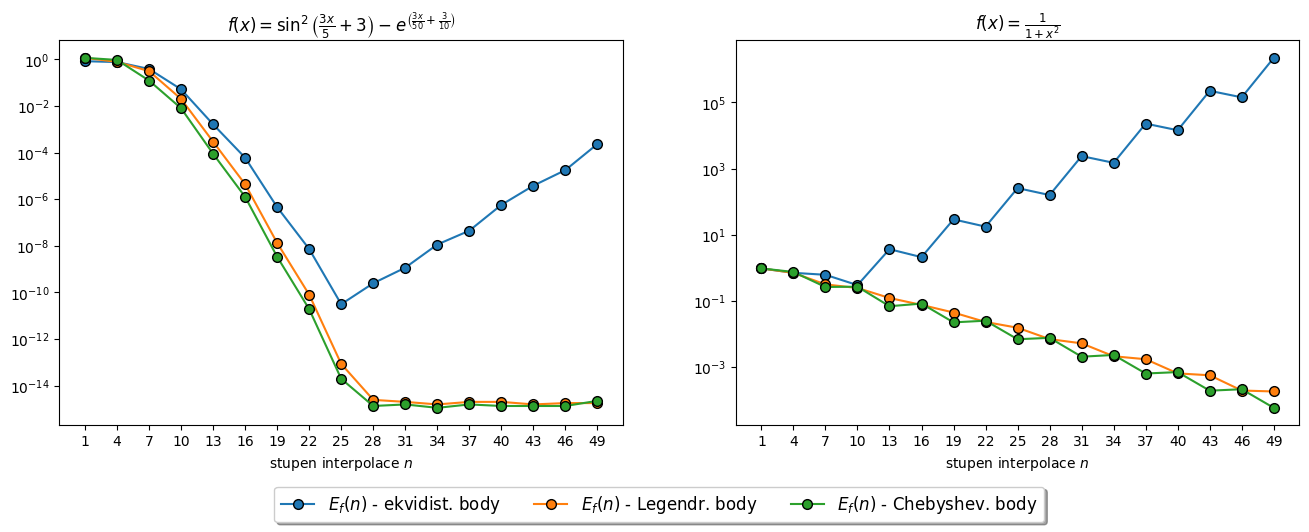

In [ ]:
def f1(x):
  return np.sin(3/5*x+3)**2 - np.exp( (3/5*x+3)/10 )
def f2(x):
  return  1/(1 + x**2)

# inicializace
a = -5; b = 5;
n_totry = np.arange(1,51,3)
E_f1_Cheb = np.zeros(len(n_totry)); E_f2_Cheb = np.zeros(len(n_totry));
E_f1_Leg = np.zeros(len(n_totry)); E_f2_Leg = np.zeros(len(n_totry));
E_f1_Equi = np.zeros(len(n_totry)); E_f2_Equi = np.zeros(len(n_totry));

# vypocet
for ind_n in range(...):

  E_f1_Cheb[ind_n] = ...
  E_f1_Leg[ind_n] = ...
  E_f1_Equi[ind_n] = ...

  E_f2_Cheb[ind_n] = ...
  E_f2_Leg[ind_n] = ...
  E_f2_Equi[ind_n] = ...



############################## Vykreslovani
fig = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.semilogy(n_totry, E_f1_Equi, "o-", ms=7, markeredgecolor="k");
plt.semilogy(n_totry, E_f1_Leg, "o-", ms=7, markeredgecolor="k");
plt.semilogy(n_totry, E_f1_Cheb, "o-", ms=7, markeredgecolor="k");
plt.xticks(n_totry); plt.xlabel("stupen interpolace $n$"); plt.title(r"$f(x) = \sin^2\left( \frac{3x}{5}+3 \right) - e^{  \left( \frac{3x}{50} +  \frac{3}{10} \right) }$")

plt.subplot(1,2,2)
plt.semilogy(n_totry, E_f2_Equi, "o-", ms=7, markeredgecolor="k", label=r"$E_f(n)$ - ekvidist. body")
plt.semilogy(n_totry, E_f2_Leg, "o-", ms=7, markeredgecolor="k", label=r"$E_f(n)$ - Legendr. body")
plt.semilogy(n_totry, E_f2_Cheb, "o-", ms=7, markeredgecolor="k", label=r"$E_f(n)$ - Chebyshev. body")
plt.xticks(n_totry); plt.xlabel("stupen interpolace $n$"); plt.title(r"$f(x) = \frac{1}{1+x^2}$")

fig.legend(loc='lower center', bbox_to_anchor=(0.5,-.1), fancybox=True, shadow=True, ncol=5, fontsize=12)
plt.show()
############################## Vykreslovani

## Část B: Spline interpolace

Místo polynomiální interpolace se teď podíváme na **po částech polynomiální interpolaci**, konkrétně na tzv. [***spliny***](https://en.wikipedia.org/wiki/Spline_(mathematics)). Začneme lineárním splinem pro interpolační body $x_0,\dotsc ,x_n$.

- Lineární spline $s^{(\ell)}(x)$ je spojitá, po částech lineární funkce, tj. na každém intervalu $(x_i,x_{i+1})$ je to lineární funkce $p_{i}(x)$.
- Lineární splňuje interpolační podmínky, tj. $s^{(\ell)}(x_i)=f_i$.

Ve výsledku tedy chceme pro dané hodnoty $f_0,\dotsc ,f_n$ a interpolační body $x_0, \dotsc , x_n$ najít koeficienty $\{ (r_i,s_i) \}_{i=0,\dotsc ,n}$ takové, že

$$
\forall i \, : \qquad  p_{i}(x) = r_ix + s_i \\
\forall i \, : \qquad  p_{i}(x_i) = p_{i+1}(x_i) = f_i
$$

a tím dostaneme náš lineární spline $s_1(x)$ předpisem

$$
\forall i \, : \qquad  s^{(\ell)}(x) := p_{i}(x) \quad \mathrm{na} \; (x_i,x_{i+1}).
$$

Na přednáčce jsme viděli, že pro hladké funkce platí odhad

$$ $$

### Úloha B1 - lineární spliny

---
**Tužka a papír** :
  - Vyjádřete vzorečky pro $r_i$ a $s_i$ na základě $f_i$ a $f_{i+1}$.
  - Jak se mění nároky na interpolační body v porovnání s polynomiální interpolací? Jsou Chebyshevovy body pořád ta správná volba? Proč?

**Kódění** : Naimplementujte funkci `LinearniSpline_Hodnoty()`, podle anotace níže.

---

'"LinearSpline_eval()" OK'

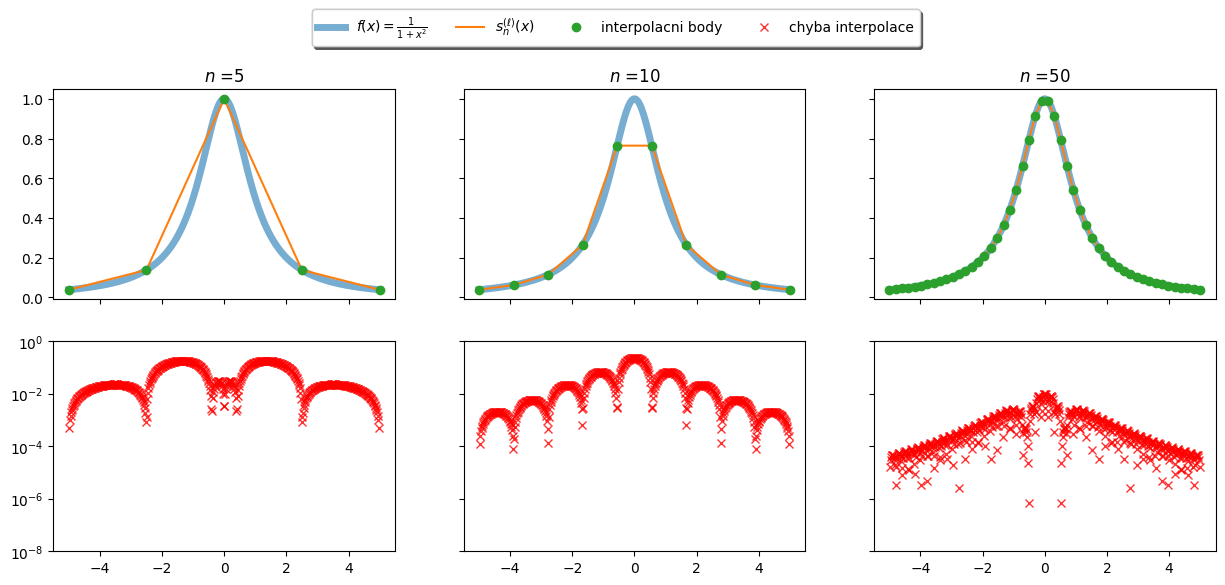

In [ ]:
def LinearniSpline_Hodnoty(f,x_interp,x_vyhodnot):
  '''
  Pro danou funkci "f" a interpolacni body "x_interp" spocitame hodnoty linearniho splinu v bodech "x_vyhodnot".

  Input
  -------
  f :   python funkce (callable). Funkce vyhodnocujici hodnoty "f : R -> R",
        syntax "f( np.array([x1,...,xn]) )" je akceptovan a vraci output "np.array([f(x1),...,f(xn)])"
  x_interp :  np.array dimenze "n+1" s prvky np.float64. Interpolacni body - rad interpolace je zadan implicitne delkou tohoto pole.
  x_vyhodnot :  np.array dimenze "m" s prvky np.float64. Body ve kterych chci vyhodnotit moji spline interpolaci.

  Output
  -------
  InterpHodnoty :  np.array dimenze "m" s prvky np.float64. Hodnoty itnerpolace "s_f" v bodech "x_vyhodnot".
  '''

  def PomocnaFce_NajdiPodInterval(t, x_interp):
    """
    Pro dany bod "t \in (x_interp[0], x_interp[-1])" najdeme index "i" takovy ze "t \in (x_interp[i], x[i+1])".
    """
    x_interp_ind = np.argmin( np.abs(t - x_interp) )
    if x_interp_ind == 0:
      MujIndex_i = 0
    elif x_interp_ind == len(x_interp)-1:
      MujIndex_i = len(x_interp) - 2
    else:
      if t <= x_interp[x_interp_ind] :
        MujIndex_i = x_interp_ind - 1
      else:
        MujIndex_i = x_interp_ind
    return MujIndex_i


  ### Váš kód

  # Jedna moznost (mozna ne ta nejefektivnejsi, ale snadna na kodovani) je pocitat pro kazdy bod `t \in x_eval` zvlast
  # Pokud pro kazde `t` najdeme dva interpolacni body `x_{i}, x_{i+1}` takove ze `t \in (x_{i}, x_{i+1})`, pak hodnota splinu je dana vzoreckem `r_i * t + s_i`, kde `r_i` a `s_i` jste si odvodili na papire.
  # Najit index `i` takovy ze `t \in (x_interp[i], x_interp[i+1])` lze pomoci funkce `PomocnaFce_NajdiPodInterval(t, x_interp)`
  SplineVals = np.zeros(len(x_vyhodnot))
  for ind in range(0,len(x_vyhodnot)):
    MujBodNaVyhodnoceni = ...
    i = ...
    r_i = ...
    SplineVals[ind] = ...

  return SplineVals


#################################################################################################
def f(x):
  return  1/(1 + x**2)

def test_LinearniSpline_eval(f):
    MyFig, MyAxis = plt.subplots(2,3,figsize=(15,6), sharex=True,sharey="row")
    n_totry = [5,10,50]
    for ind in range(0,len(n_totry)):
      a = -5; b = 5; x_plot = np.linspace(a, b, 500)
      x_interp = np.linspace(a,b,n_totry[ind])
      assert np.max( np.abs( LinearniSpline_Hodnoty(f,x_interp,x_interp) - f(x_interp) ) ) <=1e-12, "`s(x_i) = f(x_i)` by mělo platit přesně ve všech interpolačních bodech"

      currAx = MyAxis[0,ind]
      if ind == 0:
        currAx.plot(x_plot, f(x_plot), lw=5,alpha=.6, label=r"$f(x)=\frac{1}{1+x^2}$")
        currAx.plot(x_plot, LinearniSpline_Hodnoty(f,x_interp,x_plot), label=r"$s^{(\ell)}_n(x)$")
        currAx.plot(x_interp, f(x_interp), "o", label=r"interpolacni body")
        currAx.set_title(r"$n$ ={}".format(n_totry[ind]))
        currAx = MyAxis[1,ind]
        currAx.semilogy(x_plot, np.abs( f(x_plot) - LinearniSpline_Hodnoty(f,x_interp,x_plot) ), "rx", lw=0,alpha=.8, label="chyba interpolace"); currAx.set_ylim([1e-8,1]);
      else:
        currAx.plot(x_plot, f(x_plot), lw=5,alpha=.6)
        currAx.plot(x_plot, LinearniSpline_Hodnoty(f,x_interp,x_plot))
        currAx.plot(x_interp, f(x_interp), "o")
        currAx.set_title(r"$n$ ={}".format(n_totry[ind]))
        currAx = MyAxis[1,ind]
        currAx.semilogy(x_plot, np.abs( f(x_plot) - LinearniSpline_Hodnoty(f,x_interp,x_plot) ), "rx", lw=0,alpha=.8); currAx.set_ylim([1e-8,1]);
      MyFig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.025), fancybox=True, shadow=True, ncol=5);
    return '"LinearSpline_eval()" OK'

test_LinearniSpline_eval(f)

### Úloha B2: Kubické spliny

Vidíme, že pro rostoucí $n$ chyba klesá **velmi** pomalu. To se dá zlepšit použitím **polynomiálních splinů**. Jde o stejný koncept, ale místo lineárních funkcí použijeme na intervalech $(x_i,x_{i+1})$ polynomy vyššího stupně.

Klasickou volbou jsou polynomy třetího stupně, čímž dostaneme tzv. **kubické spliny**, které už `scipy` umí zkonstruovat, konkrétně funkcí  [`scipy.interpolate.CubicSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline).

Pro polynomy vyššího stupně máme přirozeně více stupňů volnosti na každém intervalu $(x_i,x_{i+1})$ a otázka je, co s nimi.
Na přednášce jsme viděli jak je využít na to, aby výsledný spline byl nejenom spojitý, ale měl spojitou i první a druhou derivaci.

<details>
<summary>Doplňující poznámka</summary>

Požadovat spojitou první i druhou derivaci nemusí být vždy ta správná volba - někdy máme nejen hodnoty funkce, ale i její derivace. Například funkce [`scipy.interpolate.CubicHermiteSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicHermiteSpline.html) sestrojí spline tak, aby měl první derivaci spojitou a aby v bodech $x_0,\dotsc, x_n$ měl spline předepsané hodnoty ($s(x_i) = f_i$) a i hodnoty první derivace ($s'(x_i) = f_i'$).

</details>

---
**Kódění** :
- Naimplementujte funkci `KubickySpline_Hodnoty()`, podle anotace níže.
- Doplňte kód níže, aby vynášel v `loglog` měřítku závislost numerické aproximace chyby $\|f(x) - s(x)\|_{\infty}$ na počtu interpolačních bodů. Interpolační body volte rovnoměrně na intervalu $[a,b]$.

**Tužka a papír** :
- Odhadněte řád konvergence pro lineární a kubický spline na základě vykresleného obrázku, tj. odhadněte $\alpha$ takové, že $\|f(x) - s(x)\|_{\infty} \approx C\cdot n^{\alpha}$ pro každý ze splinů.
- Porovnejte výsledky s přednáškou - jaké máme odhady a jak dobře popisují naše experimenty?
---


'"KubickySpline()" OK'

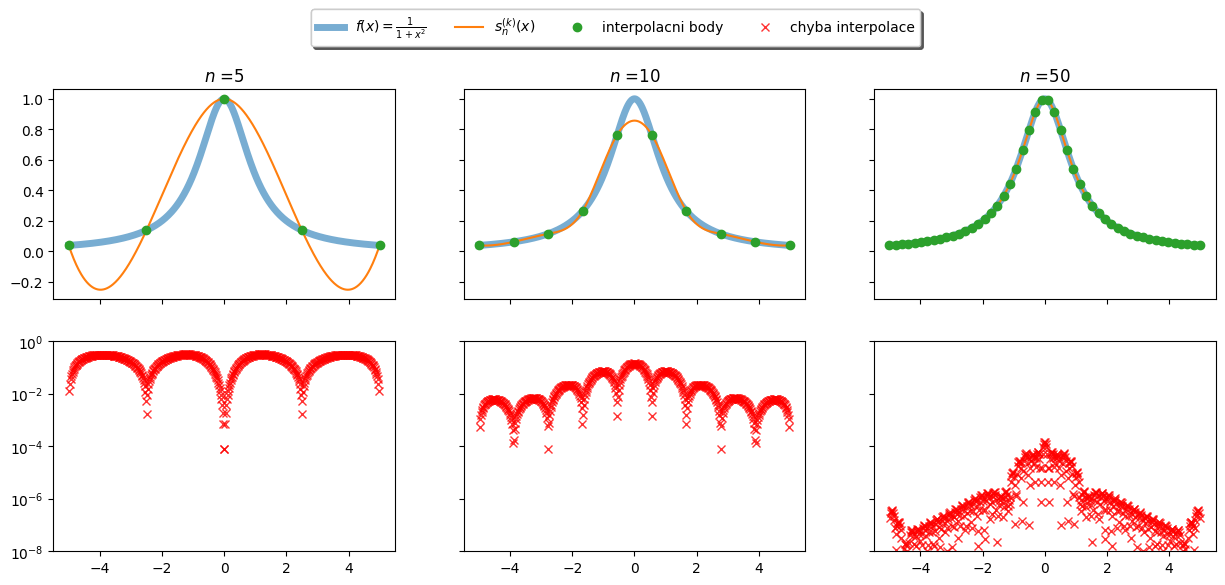

In [ ]:
def KubickySpline_Hodnoty(f,x_interp,x_vyhodnot):
  '''
  Pro danou funkci "f" a interpolacni body "x_interp" spocitame hodnoty kubickeho splinu v bodech "x_vyhodnot".

  Input
  -------
  f :   python funkce (callable). Funkce vyhodnocujici hodnoty "f : R -> R",
        syntax "f( np.array([x1,...,xn]) )" je akceptovan a vraci output "np.array([f(x1),...,f(xn)])"
  x_interp :  np.array dimenze "n+1" s prvky np.float64. Interpolacni body - rad interpolace je zadan implicitne delkou tohoto pole.
  x_vyhodnot :  np.array dimenze "m" s prvky np.float64. Body ve kterych chci vyhodnotit moji spline interpolaci.

  Output
  -------
  InterpHodnoty :  np.array dimenze "m" s prvky np.float64. Hodnoty itnerpolace "s_f" v bodech "x_vyhodnot".
  '''
  # Váš kód
  KubickySpline = ...
  return KubickySpline(...)

################################################################################
def f(x):
  return  1/(1 + x**2)

def test_KubickySpline(f):
  MyFig, MyAxis = plt.subplots(2,3,figsize=(15,6), sharex=True,sharey="row")
  n_totry = [5,10,50];
  for ind in range(0,len(n_totry)):
    a = -5; b = 5; n=n_totry[ind]; x_plot = np.linspace(a, b, 500)
    ### ekvidistantni interpolacni body
    x_interp = np.linspace(a,b,n)
    assert np.allclose( KubickySpline_Hodnoty(f,x_interp,x_interp), f(x_interp) ), "`s(x_i) = f(x_i)` by mělo platit přesně ve všech interpolačních bodech"
    xx = np.sort( np.random.rand(5)*(b-a) + a )
    assert np.allclose( KubickySpline_Hodnoty(f,x_interp,xx), CubicSpline(x_interp,f(x_interp))(xx) ), "Něco je tam špatně, zkus se poradit/zamyslet."

    currAx = MyAxis[0,ind]
    if ind == 0:
      currAx.plot(x_plot, f(x_plot), lw=5,alpha=.6, label=r"$f(x)=\frac{1}{1+x^2}$")
      currAx.plot(x_plot, KubickySpline_Hodnoty(f,x_interp,x_plot), label=r"$s^{(k)}_n(x)$")
      currAx.plot(x_interp, f(x_interp), "o", label=r"interpolacni body")
      currAx.set_title(r"$n$ ={}".format(n_totry[ind]))
      currAx = MyAxis[1,ind]
      currAx.semilogy(x_plot, np.abs( f(x_plot) - KubickySpline_Hodnoty(f,x_interp,x_plot) ), "rx", lw=0,alpha=.8, label="chyba interpolace"); currAx.set_ylim([1e-8,1]);
    else:
      currAx.plot(x_plot, f(x_plot), lw=5,alpha=.6)
      currAx.plot(x_plot, KubickySpline_Hodnoty(f,x_interp,x_plot))
      currAx.plot(x_interp, f(x_interp), "o")
      currAx.set_title(r"$n$ ={}".format(n_totry[ind]))
      currAx = MyAxis[1,ind]
      currAx.semilogy(x_plot, np.abs( f(x_plot) - KubickySpline_Hodnoty(f,x_interp,x_plot) ), "rx", lw=0,alpha=.8); currAx.set_ylim([1e-8,1]);
    MyFig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.025), fancybox=True, shadow=True, ncol=5);
  return '"KubickySpline()" OK'
test_KubickySpline(f)

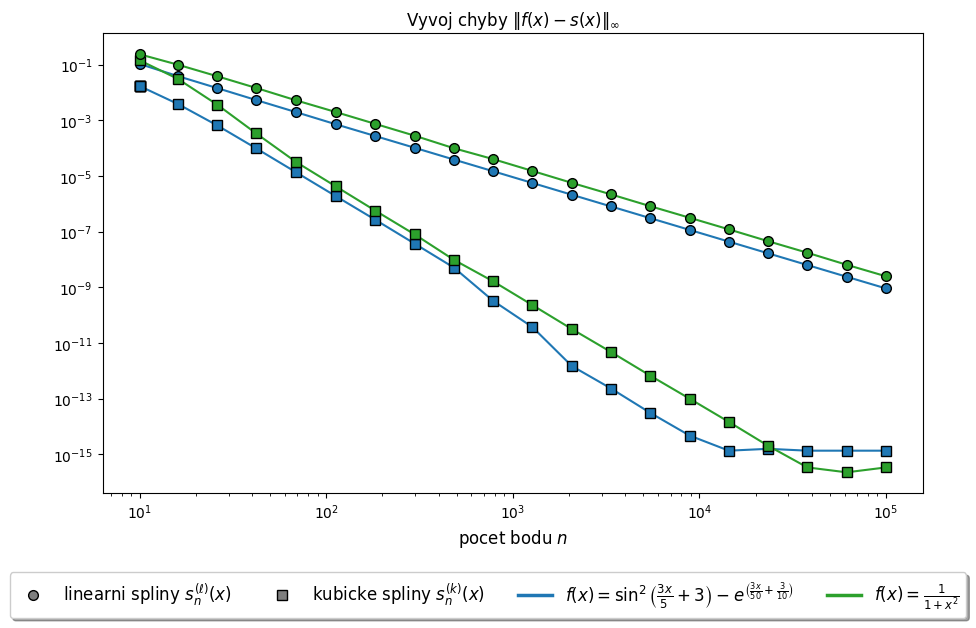

In [ ]:
def f1(x):
  return np.sin(3/5*x+3)**2 - np.exp( (3/5*x+3)/10 )
def f2(x):
  return  1/(1 + x**2)

# inicializace
n_totry = np.logspace(1,5,20,dtype=np.int32); h_totry = 1/(n_totry-1);
E_kub_f1 = np.zeros(len(n_totry)); E_lin_f1 = np.zeros(len(n_totry));
E_kub_f2 = np.zeros(len(n_totry)); E_lin_f2 = np.zeros(len(n_totry));
a = -5; b = 5; x_chyba = np.linspace(a,b,1000)

# vypocet
for ... :

  E_kub_f1[ind_n] =
  E_lin_f1[ind_n] =
  E_kub_f2[ind_n] =
  E_lin_f2[ind_n] =


############################## Vykreslovani
plt.figure(figsize=(9, 6))

plt.loglog(n_totry, E_kub_f1, "s-", ms=7, c="tab:blue", markeredgecolor="k")
plt.loglog(n_totry, E_lin_f1, "o-", ms=7, c="tab:blue", markeredgecolor="k")
plt.loglog(n_totry, E_kub_f2, "s-", ms=7, c="tab:green", markeredgecolor="k")
plt.loglog(n_totry, E_lin_f2, "o-", ms=7, c="tab:green", markeredgecolor="k")
plt.xlabel("pocet bodu $n$", fontsize=12); plt.title(r"Vyvoj chyby $\|f(x) - s(x)\|_{\infty}$")

ax = plt.gca(); fig = plt.gcf(); all_handles = []; all_labels = []
line1, = ax.loglog([n_totry[0],n_totry[0]],[E_kub_f1[0],E_kub_f1[0]], '-', lw=0, marker="o", ms=7,markeredgecolor="k",color="tab:gray")
line2, = ax.loglog([n_totry[0],n_totry[0]],[E_kub_f1[0],E_kub_f1[0]], '-', lw=0, marker="s", ms=7,markeredgecolor="k",color="tab:gray")
line3, = ax.loglog([n_totry[0],n_totry[0]],[E_kub_f1[0],E_kub_f1[0]], '-', lw=2.5, color="tab:blue")
line4, = ax.loglog([n_totry[0],n_totry[0]],[E_kub_f1[0],E_kub_f1[0]], '-', lw=2.5, color="tab:green")
ax.loglog([n_totry[0],n_totry[0]],[E_kub_f1[0],E_kub_f1[0]], 's', lw=0, ms=7, c="tab:blue", markeredgecolor="k")

all_handles.extend([line1, line2, line3, line4])
all_labels.extend([r'linearni spliny $s^{(\ell)}_n(x)$',
                   r'kubicke spliny $s^{(k)}_n(x)$',
                   r'$f(x) = \sin^2\left( \frac{3x}{5}+3 \right) - e^{  \left( \frac{3x}{50} +  \frac{3}{10} \right) }$',
                   r"$f(x) = \frac{1}{1+x^2}$"])
fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=4, fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
############################## Vykreslovani

## [Kvíz](https://forms.gle/8nbtCFSgnw8QAyEL6)